# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [3]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distribution of the input pixels. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


# ANSWER TO : 1.1 b
ELBO

We separate the ELBO loss of the VAE into two components. The first component corresponds to the reconstruction error between the output and the input. An important thing to consider in this step is that the data is continuous. In order to appropriately model p(x|z) using binary cross entropy, we first transform the input image into binary form through the transform lambda x:x.round(). This allows the decoder to properly capture 28*28 Bernoulli parameters at the output, returned from the last layer through a sigmoid activation function. This decision was proved beneficial as it showed to increase performance signficantly in contrast to leaving the input image in the continuous domain [0,1].

Notice that we reduce through 'sum' in the loss function as we want the sum of log probabilities for all pixels in the mini-batch (Monte-Carlo approximation).

The second component corresponds to the negative Kullback-Lieber divergence between the variational posterior and the prior on z (latent variable). Notice that the KLD has a closed-form solution as the gaussian posterior is diagonal and the prior is unit diagonal. KLD can be though of as a regularisation term which enforces q(z|x) to approach p(z|x). A gaussian sampler is appropriate as it follows through the central limit theorem that the average of samples of any distribution tends to follow a gaussian distribution (as number of samples tends to infinity).

BETA

The KLD term is augmented by the variable beta_kld. What I found from the graphical representations is that latent space becomes more more structured/disentagled when increasing beta_kld. This makes sense because increasing beta_kld attempts to make the probability distributions from the latent space closer to a true gaussian and so having this contribution enforces a gaussian structure. In contrast when we reduce beta_kld, the BCE gains priority and the latent space adapts heavily to reduce the reconstruction loss, losing/rejecting information about its prior. Consequently features from the latent space may become correlated with one another and so it is harder to differentiate between some classes (i.e. 0s and 8s). This comes at the cost of increased reconstruction errors. The optimal value for beta_kld of 2 was found through qualitative exploration, comproming between reconstruction loss and generalisability (from to a well defined continuous structure in the latent space).


In [56]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

#from fastprogress import master_bar, progress_bar

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

# Create a folder if it does not exist
if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')

cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 15
learning_rate = 4e-04  
batch_size = 128
### Choose a value for the size of the latent space
latent_dim = 20

###
# Beta for KLD amplification
beta_kld = 2

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
     #transforms.Normalize(mean=(0.5,), std=(0.5,))
     lambda x: x.round() # Make it Bernoulli - Like. This will improve the loss propagation from the softmax output
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x #/2+0.5

## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')

## Model Definition

In [59]:
# *CODE FOR PART 1.1a IN THIS CELL*
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Convolution Followed by FFNN to the 2*latent_dim (latent dimension vector
        # for both mean and standard deviation)

        self.latent_dim = latent_dim

        self.inference_net = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, 
                      kernel_size = 3, stride=2, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 32, 
                      kernel_size = 3, stride=2, 
                      padding=1),
            nn.ReLU(),        
            nn.Conv2d(in_channels = 32, out_channels = 64, 
                      kernel_size = 3, stride = 1,
                      padding = 0),
            Flatten(),
            nn.Linear(64*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, self.latent_dim + self.latent_dim))

        # Decoder is a FFNN followed by transpose convolution
        self.conv_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, 64*5*5),
            View((-1, 64, 5, 5)),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, 
                               stride = 1, kernel_size = 3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32,out_channels = 16,
                               kernel_size = 3, stride=2, 
                               padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 1, 
                               kernel_size = 3, stride=2, 
                               padding=1, output_padding=1),
            nn.Sigmoid() # Output is from 0 to 1
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Split latent space vector
        mean, logvar = torch.chunk(self.inference_net(x), chunks = 2, dim=1)

        return mean, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Sample from the latent space
        if self.training:
          std = torch.exp(0.5*logvar)
          eps = torch.randn_like(std)
          return mu + eps*std
        else:
            return mu
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        return self.conv_decoder(z)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Encoder
        mu_net, logvar_net = self.encode(x)
        z = self.reparametrize(mu_net, logvar_net)

        # Decoder
        x_reconstructed = self.decode(z)

        # Output: reconstruced x and last 2 terms needed for KL loss. 
        return x_reconstructed, mu_net, logvar_net
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 450529
VAE(
  (inference_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): Flatten()
    (6): Linear(in_features=1600, out_features=120, bias=True)
    (7): ReLU()
    (8): Linear(in_features=120, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=40, bias=True)
  )
  (conv_decoder): Sequential(
    (0): Linear(in_features=20, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=1600, bias=True)
    (5): View()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(

## Training loop

In [60]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(model, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Try the continuous bernoulli 
        # https://papers.nips.cc/paper/9484-the-continuous-bernoulli-fixing-a-pervasive-error-in-variational-autoencoders.pdf

        x_reconstructed, mu_net, logvar_net = model.forward(x)

        # First Part :: Binary Cross Entropy loss (BCE)
        BCE = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')

        # Second Part :: Kulback-Lieber Divergence loss (KLD)
        KLD = -0.5 * torch.sum(1 + logvar_net - mu_net.pow(2) - logvar_net.exp())
        # KLD /= batch_size * 784
        
        return beta_kld*KLD + BCE, BCE, beta_kld*KLD
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

LOG_INTERVAL = 250
train_loss_arr = []
test_loss_arr = []
bCompareTest = True

for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        model.train()

        train_loss = 0
        train_loss_BCE = 0
        train_loss_KLD = 0

        test_loss = 0
        test_loss_BCE = 0
        test_loss_KLD = 0

        # in the case of MNIST, len(loader_train.dataset) is 60000
        # each `data` is of BATCH_SIZE samples and has shape [64, 1, 28, 28]

        for batch_idx, (data, _) in enumerate(loader_train):
          data = data.to(device)
          optimizer.zero_grad()
          x_reconstructed_batch, _, _ = model(data)
          loss, BCE_loss, KLD_loss = loss_function_VAE(model, data)
          train_loss += loss.item()
          train_loss_BCE += BCE_loss.item()
          train_loss_KLD += KLD_loss.item()

          loss.backward()
          optimizer.step()

          if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader_train.dataset),
                100. * batch_idx / len(loader_train),
                loss.data / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(loader_train.dataset)))
        
        train_loss_arr.append((train_loss, train_loss_BCE, train_loss_KLD))

        if bCompareTest:
          with torch.no_grad():
            for data, _ in loader_test:
              data = data.to(device)
              x_reconstructed_batch, _, _ = model(data)
              loss, BCE_loss, KLD_loss = loss_function_VAE(model, data)
              test_loss += loss.item()
              test_loss_BCE += BCE_loss.item()
              test_loss_KLD += KLD_loss.item()
        
        test_loss_arr.append((train_loss, train_loss_BCE, train_loss_KLD))

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

Train Epoch: 0 [0/60000 (0%)]	Loss: 531.058289
Train Epoch: 0 [32000/60000 (53%)]	Loss: 201.470108
====> Epoch: 0 Average loss: 228.8031
Train Epoch: 1 [0/60000 (0%)]	Loss: 200.808167
Train Epoch: 1 [32000/60000 (53%)]	Loss: 179.616608
====> Epoch: 1 Average loss: 179.1200
Train Epoch: 2 [0/60000 (0%)]	Loss: 171.035126
Train Epoch: 2 [32000/60000 (53%)]	Loss: 160.464233
====> Epoch: 2 Average loss: 154.8627
Train Epoch: 3 [0/60000 (0%)]	Loss: 144.275391
Train Epoch: 3 [32000/60000 (53%)]	Loss: 139.735214
====> Epoch: 3 Average loss: 140.2153
Train Epoch: 4 [0/60000 (0%)]	Loss: 133.247787
Train Epoch: 4 [32000/60000 (53%)]	Loss: 136.158203
====> Epoch: 4 Average loss: 132.2487
Train Epoch: 5 [0/60000 (0%)]	Loss: 137.259537
Train Epoch: 5 [32000/60000 (53%)]	Loss: 126.195442
====> Epoch: 5 Average loss: 127.0657
Train Epoch: 6 [0/60000 (0%)]	Loss: 130.386414
Train Epoch: 6 [32000/60000 (53%)]	Loss: 125.829880
====> Epoch: 6 Average loss: 123.5798
Train Epoch: 7 [0/60000 (0%)]	Loss: 121.0

### Your explanations about the loss function here:

## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


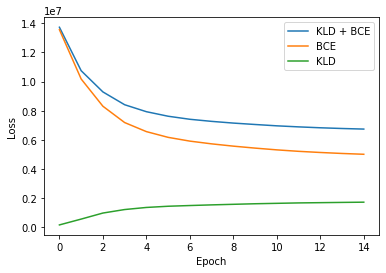

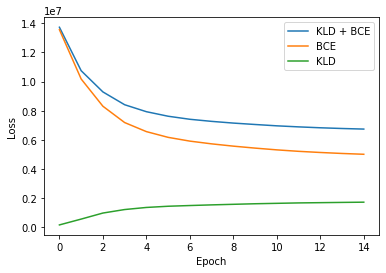

In [32]:
# *CODE FOR PART 1.2a IN THIS CELL*

legend = ["KLD + BCE","BCE","KLD"]

plt.plot(train_loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(legend)

plt.figure()
plt.plot(test_loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(legend)

### Your answer to 1.2b here:

GENERAL ANSWER

The general trend for the test and training samples is very similar. This showcases that the model is not overfitting. The BCE loss is greater in magnitude than the KLD and hence the optimiser tries to reduce this in preference. As mentioned in pat 1.1, KLD can be though of as a regularisation term which enforces q(z|x) to approach p(z|x).

If the loss was solely based on KLD, the latent space would have no structure other than that given by its gaussian prior (0 mean, unit standard deviation) as this would force the encodings to be represented by a single cluster. If it were to attempt to diverge to a different structure/distribution by clustering them apart into specific regions (losing gaussian distribution) away from its origin, it would be penalised and so KLD would increase. In order to reduce the reconstruction loss, the KLD must therefore be penalised as the encodings separate from one another, allowing the VAE to cluster specific encodings next to one another (reducing BCE loss). It is important to balance out the contribution from KLD as if it was too large, then the latent space representations for i.e. (6 and 8) could end up overlapping. Note that the increase in KLD and the decrease in BCE are both very stable which is a good indicator: under the good reconstruction, the latent variable captures more useful information (hence the previously discussed effects on beta_kld).

In contrast, if we set the KLD loss to 0 (effectively setting beta_kld to 0), this would allow the clusters of i.e. (6, 8) to separate as much as the reconstruction loss would allow it to. This would be catastrophic during generation of new samples and interpolation as we would have to cross latent space domains which are not covered by the encoder-decoder.

POSTERIOR COLLAPSE

Posterior collapse is a common issue with generative modeles such as VAE, where the variational distribution collapses towards the prior and begins to ignore the samples z drawn from the posterior (this is typically referenced to the KLD term in the ELBO). We observed posterior collapse when beta_kld is increased a lot i.e. up to 10. This inherently makes the latent space representation of the mean and standard deviation redundant and so driving p(z|x) to approximate to p(z), a latent space which has been learnt to minimise an overall reconstruction (sub-optimal). This reduces the capacity of the generative model as it inhibits the decoder network from making use of the information content of the latent dimensions. This was observed during reconstruction where the generation of number between 0-9 became very noisy (posterior collapse). Note that the BCE loss is in comparison small when beta_kld is large. This means that the reconstruction loss is not predominant and so the VAE focusses on producing posterior distributions similar to the gaussian prior.

During posterior collapse, the VAE outputs are independent of the inputs. With high betas and thus high KLD contribution we observed that the outputs are always the same (corresponding to an intermediate point which satisfies all labels). This is clearly posterior collapse and it can be mitigated by controlling beta_kld to a relatively low value.

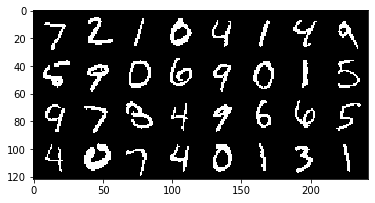

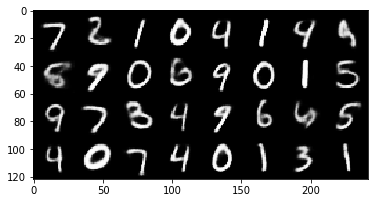

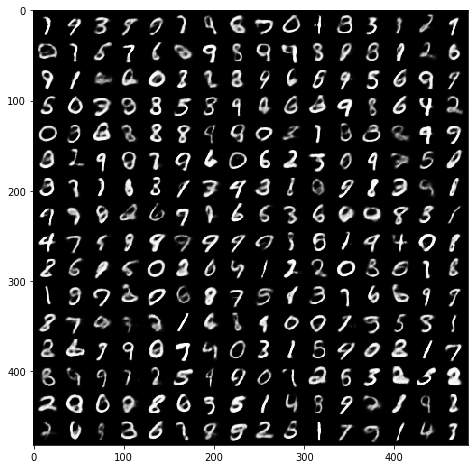

In [61]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, mu_net , logvar_net = model.forward(fixed_input.to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


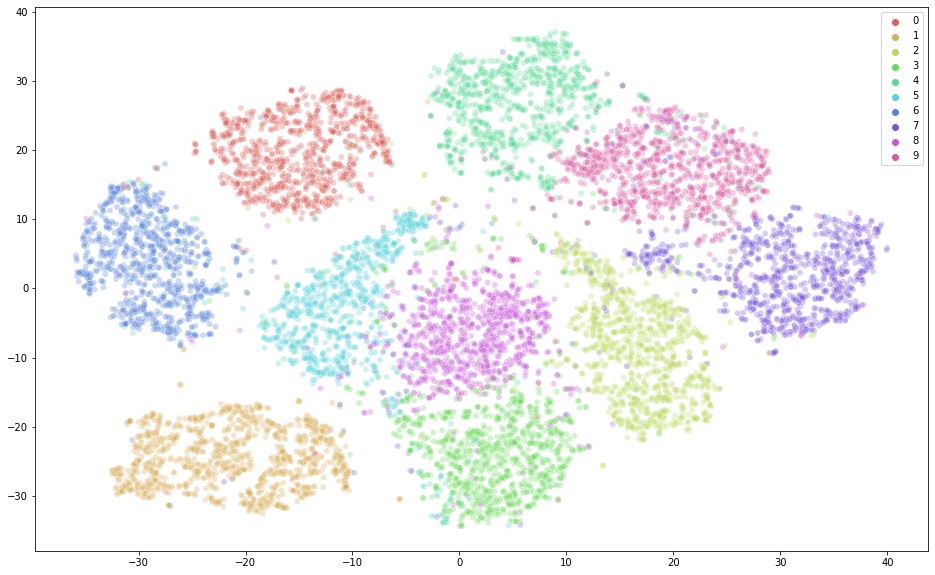

In [62]:
# *CODE FOR PART 1.3a IN THIS CELL*
# LATENT REPRESENTATIONS
from sklearn.manifold import TSNE
import seaborn as sns

model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
testing_data = ((loader_test.dataset.test_data).view(-1,1,28,28)).float()
testing_data /= 255 # Normalise between 0 and 1 (Bernoulli reconstruction)
testing_labels = loader_test.dataset.test_labels

z_mean, z_logvar = model.encode(testing_data.to(device))
z = model.reparametrize(z_mean, z_logvar)
z = z.cpu()

with torch.no_grad():
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500)
    tsne_results = tsne.fit_transform(z.detach().numpy())

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=tsne_results[:,0], y=tsne_results[:,1],
        hue=testing_labels,
        palette=sns.color_palette("hls", 10),
        legend="full",
        alpha=0.3
    )

### Your answer to 1.3a here:

In this figure (tSNE on the latent space features) we observe how the different labels (numbers) are separated in different clusters within the latent space. Indeed some numbers are closer together. If you take a closer look at 8, 5 and 3, these clusters are very close by, showcasing that there is a structure in the latent space representation. Ideally there would be no "gaps/white space" within the tSNE representation. The fact that some gaps exist showcase that the BCE loss prioritised separation from the gaussian prior in contrast to the KLD loss. This is evident between the clusters of labels 6 and 0. 

When testing this visualisation at different beta_kld values we found that reducing beta increases the distance between clusters. This is because the posterior is not as constrained by the KLD, and so the latent space loses structure. In contrast, the clusters overlap significantly when beta is increased, up to the point where posterior collapse occurs (at betas above 10) and the tSNE plot shows no clear clusters within labels but is rather chaotic. 

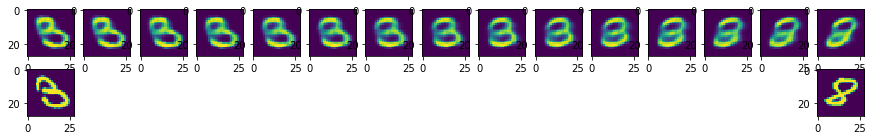

In [39]:
# *CODE FOR PART 1.3b IN THIS CELL*
# LINEAR INTERPOALTONS
import torch
# We have our data now: testing_data and labels: testing_labels

def interpolate(index1, index2, nInterpolate = 10):

    N1 = torch.sum(testing_labels == index1)
    N2  = torch.sum(testing_labels == index2)

    N = min(N1, N2)

    reference = testing_data[testing_labels == index1][:N]
    goal = testing_data[testing_labels == index2][:N]

    reference = reference.to(device)
    goal = goal.to(device)

    z_mean1, z_logvar1 = model.encode(reference)
    z1 = model.reparametrize(z_mean1, z_logvar1)
    z1 = z1.cpu()

    z_mean2, z_logvar2 = model.encode(goal)
    z2 = model.reparametrize(z_mean2, z_logvar2)
    z2 = z2.cpu()    

    embedding_values = [z2 * (i/nInterpolate) + z1 * (nInterpolate-i)/nInterpolate for i in range(nInterpolate)]
    recons = [model.decode(embed.to(device)) for embed in embedding_values]
    recons = torch.stack(recons)

    recons = recons.cpu()
    reference = reference.cpu()
    goal = goal.cpu()

    plt.figure(figsize=(nInterpolate, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,nInterpolate,i+1)
        plt.imshow(recon[0][0])
    plt.subplot(2,nInterpolate,nInterpolate + 1)
    plt.imshow(reference[0][0])
    plt.subplot(2,nInterpolate,nInterpolate * 2)
    plt.imshow(goal[0][0])

emb_smooth = interpolate(3, 8, 15)

### Your answer to 1.3b here:

We can perform interpolation from one latent space to another. This has been seen in many examples in literature and thus is no exception to the rule. Above we observe the interpolation between 3 and 8. Clearly there is a direct relationship between the two cluster spaces for the latter 2 numbers. Note that these numbers are close together in the visualisation provided in the latter cell (tSNE) and so this means that the latent space representation can be interpolated from one cluster space smoothly. In contrast, when doing so between 0 and 2 we observe a rougher transiton (shown below): notice that it seems like an 8 is observed in the middle of the interpolation sequence and so the interpolation is not clear.

This behaviour could be predicted in a prior stage as these clusters show a "white gap" in (tSNE) created by the compromise to minimise reconstruction loss.

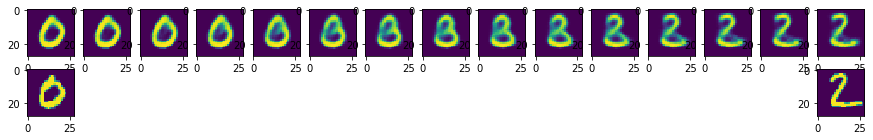

In [41]:
emb_rough = interpolate(0, 2, 15)

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [2]:
batch_size = 128  
NUM_TRAIN = 49000
image_size = 32
num_channels_RGB = 3

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p = 0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Lambda(lambda x: np.clip(x + 0.05*torch.randn_like(x), -1,1)),
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 40
learning_rate_G = 4e-04
learning_rate_D = 2e-04
latent_vector_size = 32
###

# Define here other hyperparameters that you used.

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.nz = latent_vector_size
        self.nGFactor = 48 # Feature map expandor for the generator
        self.nc = 3 # input image channels

        self.decoder = nn.Sequential(
            # INPUT TRANSPOSE CONVOLUTION
            nn.ConvTranspose2d(in_channels = self.nz, out_channels = self.nGFactor * 4, 
                               kernel_size = 4, stride = 1, 
                               padding = 0, bias=False),
            nn.BatchNorm2d(self.nGFactor * 4),
            nn.ReLU(True), # ReLU inplace operator saves GPU memory!
                # state size. (self.nGFactor * 4) x 4 x 4

            # SECOND LAYER TRANSPOSE CONVOLUTION
            nn.ConvTranspose2d(in_channels = self.nGFactor * 4, out_channels = self.nGFactor * 2, 
                               kernel_size = 4, stride = 2,
                               padding = 1, bias=False),
            nn.BatchNorm2d(self.nGFactor * 2),
            nn.ReLU(True),
                # state size. (self.nGFactor * 2) x 8 x 8

            # THIRD LAYER TRANSPOSE CONVOLUTION
            nn.ConvTranspose2d(in_channels = self.nGFactor * 2, out_channels = self.nGFactor, 
                               kernel_size = 4, stride = 2, 
                               padding = 1, bias=False),
            nn.BatchNorm2d(self.nGFactor),
            nn.ReLU(True),
                # state size. (self.nGFactor) x 16 x 16

            # OUTPUT LAYER TRANSPOSE CONVOLUTION
            nn.ConvTranspose2d(in_channels = self.nGFactor, out_channels = self.nc, 
                               kernel_size = 4, stride = 2, 
                               padding = 1, bias=False),
            nn.Tanh())
                # state size. (self.nc) x 32 x 32

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Are we supposed to sample ???
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return self.decoder(z)

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.nDFactor = 64 # Feature map expandor for discriminator is larger than the generator
        self.nc = 3 # input image channels

        self.discriminant = nn.Sequential( 

            # Input image is (self.nc) x 32 x 32
            nn.Conv2d(in_channels = self.nc, out_channels = self.nDFactor, 
                      kernel_size = 4, stride=2, 
                      padding=1, bias = False),
            nn.BatchNorm2d(self.nDFactor),
            nn.LeakyReLU(0.2, True),
                 # state size. (self.nDFactor) x 16 x 16

            nn.Conv2d(in_channels = self.nDFactor, out_channels = self.nDFactor * 2, 
                      kernel_size = 4, stride=2, 
                      padding=1, bias = False),
            nn.BatchNorm2d(self.nDFactor * 2),
            nn.LeakyReLU(0.2, True),
                # state size. (self.nDFactor*2) x 8 x 8

            nn.Conv2d(in_channels = self.nDFactor * 2, out_channels = self.nDFactor * 4, 
                      kernel_size = 4, stride = 2,
                      padding = 1, bias = False),
            nn.BatchNorm2d(self.nDFactor * 4),
            nn.LeakyReLU(0.2, True),
                # state size. (self.nDFactor*8) x 4 x 4

            # Output to classification "binary"
            nn.Conv2d(self.nDFactor * 4, out_channels = 1, 
                      kernel_size = 4, stride = 1, 
                      padding = 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.discriminant(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters





You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [27]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 469920
Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 663424
Discriminator(
  (discriminant): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer and add a scheduler!
beta1 = 0.5

optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size = 1, gamma = 0.95)

optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size = 2, gamma = 0.95)

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [31]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        
        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())

        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

    print("Epoch {}, loss_D {}, loss_G {}".format(epoch, train_loss_D, train_loss_G))

    if schedulerD is not None and schedulerG is not None:
        schedulerD.step()
        schedulerG.step()

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

Epoch 0, loss_D 0.5594048500061035, loss_G 2.9961204528808594
Epoch 1, loss_D 0.6221405267715454, loss_G 2.042947292327881
Epoch 2, loss_D 1.148245096206665, loss_G 1.4952677488327026
Epoch 3, loss_D 1.165653944015503, loss_G 1.402069091796875
Epoch 4, loss_D 0.8956678509712219, loss_G 1.3391203880310059
Epoch 5, loss_D 1.125664472579956, loss_G 1.2364203929901123
Epoch 6, loss_D 1.0579900741577148, loss_G 1.6563054323196411
Epoch 7, loss_D 0.8900600671768188, loss_G 1.3819830417633057
Epoch 8, loss_D 1.0995880365371704, loss_G 1.177815556526184
Epoch 9, loss_D 0.9441999197006226, loss_G 1.5098228454589844
Epoch 10, loss_D 1.0613784790039062, loss_G 1.221205472946167
Epoch 11, loss_D 0.7555274963378906, loss_G 1.59983229637146
Epoch 12, loss_D 1.0570449829101562, loss_G 1.1772630214691162
Epoch 13, loss_D 1.1394739151000977, loss_G 1.093603491783142
Epoch 14, loss_D 1.0951892137527466, loss_G 1.0239863395690918
Epoch 15, loss_D 0.9796178340911865, loss_G 1.2065138816833496
Epoch 16, lo

### Generator samples

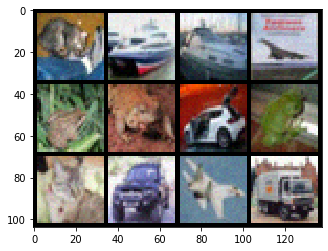

In [11]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:12, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

# Representation of real images

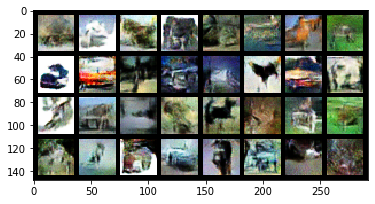

In [55]:
#load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=4, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

# Sample images generated with DCGAN (row 3 column 5 looks like a dog and row 2 column 1 looks like a blue + white truck etc.)

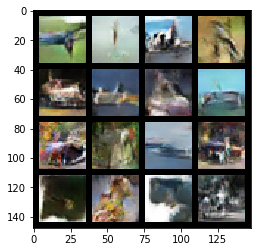

In [223]:
# Note that some images look like birds (top left) and some other like boats (2nd row 1st column and 3, 4th column) etc.

## ANSWER TO PART 2.1 (C) HERE

Initially I started with a simple CNN decoder in the generator using 2 layers of CNN-based upsampling (transpose convolution) linked through ReLU activations followed by a maxpool layer. Note that the input latent space dimension was initially set to 20. A tanh activation function was used at the output layer, normalising the generated image between [-1, 1]. Batchnorm was also implemented. This allowed the layers to be more independent from one another and hence the need for dropout was reduced. Moreover convergence and stability of the network is ameliorated as the behavour of backpropagated gradients are smoothed out (in a similar manner to how we would normalise the output features of a regressor to improve loss propagation). Batchnorm was found to be necessary for convergence of the DCGAN. 

The generator was then passed into a discriminator of a similar architecture. The key differences is that the layers were fully convolutional layers linked through LeReLU activations. Leaky ReLUs are used to improve gradient backpropagation from the discriminator to the generator: there are many layers in between the generator input and the discriminator output which may contribute to vanishing gradients when the linear layers have negative outputs (0 otherwise with ReLU). Althoguh the non-linearity is not as preserved LeReLU ameliorates this by consistently passing gtradients to prior stages. Indeed this ammends the need for fine initialisation (LeReLU can allow faster adaptation to uneven initialisation). The output of the discriminator is constructed via a CNN of kernel size 1, reducing the number of channels to an output dimension of 1. This is subsequently passed by a softmax activation, allowing for propper classification (TRUE or FALSE image) over the generated image. Once again batchnorm was included. 

Note that (although having played with kernel sizes) this resulted in slow or insufficient convergence. An additional convolutional layer was subsequently added to both the generator and the discriminator. Moreover it was found that a maxpool layer was not required. Noteworthy is that fully convolutional layers were set as the norm in the architecture design in contrast to the VAE design proposed in part 1. This allowed fast computation through the GPU provided. 

An important aspect to the successful learning of the DCGAN is the scheduler (scheduler_d, scheduler_g). Including schedulers is thought of a way in which the discriminator can stabilise beforehand: forcing the learning rate of the discriminator to decrease faster than the generator allows the discriminator to settle. Through experimentation it was found that initialising the generatior learning rate to 4e-04 whilst dropping the learning rate for the discriminator to 2e-04 was beneficial to keeping the Nash equilibrium (min max problem). Note this is a different approach to that encountered in lectures where it is suggested to halt training of the generator for k batch iterations whilst the discriminator is trained, however it follows the same principles. Indeed this helped significantly in practice.  

In order to perform data augmentation we included several transforms: {RandomNoise, RandomCrop, RandomFlip, Resize}. The former (RandomNoise) was included in order to improve convergence of the discriminator as suggested in (https://arxiv.org/pdf/1701.04862.pdf).

After observing the convergence of the architecture it was found that increasing the latent space to 32 was beneficial as this hindered mode collapse and stabilised the nash equilibrium between the discriminator and the generator. This is shown below in the figures (plots for part (b)), where mode collapse is observed when using a latent space of low dimensions 20: all images show similar patterns whilst the discriminator loss is very high compared to the generaor.

In the optimal model we increased the number of channels significantly, allowing slow but steady convergence. It was found that enriching the discriminator with more channels was beneficial, hence the variable multiplier nGFactor was set to 48 whilst nDFactor was set to 64. This came at the expense of additional training epochs required (40 epochs). In contrast it was difficult to achieve fast and stable convergence with a "smaller" DCGANs.

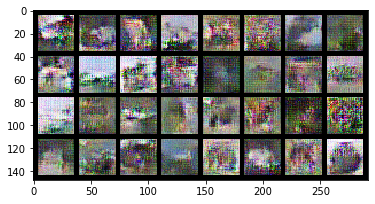

In [105]:
# GENERATED IMAGES APPROXIMATE MODE COLLAPSE WITH LATENT SPACE OF DIMENSION 20 at epoch 20

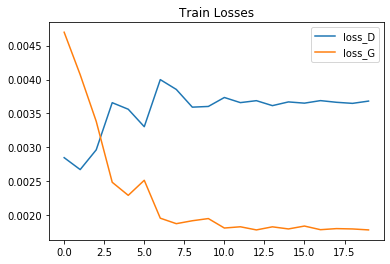

In [108]:
# CORRESPONDING LOSS v EPOCHS FOR A LATENT SPACE OF 20. MODE COLLAPSE OBSERVED AS DISCRIMINATOR IS GETTING FOOLED (high loss) EVEN WHEN THE GENERATOR GENERATES "RUBBISH" IMAGES

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

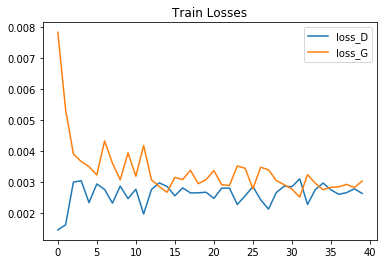

In [49]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

# This is the loss graph for the optimal model submitted in this coursework! Note that if we multiply the y_axis by the batch size (128) then we find that the discriminator stabilises
# at a loss of 0.4. This is very good considering that the optimal is 0.5!

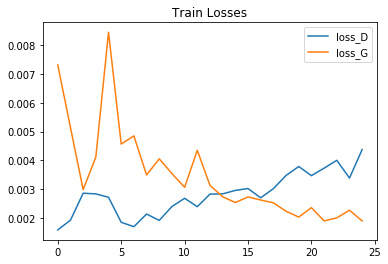

In [251]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

# Here the discriminator starts deviating too much, in theory we would like stable equilibrium learning as seen between epochs 12 and 17

# Answer to part 2.2

The generator loss is decreasing during training epochs which implies that the discriminator tends to detect fake images generated by the generator as real. The discriminator loss is consequently increasing as it is being fooled by the generator. However, it is crucial that the discriminator loss does not surpass the point where the discriminator deviates into predicting "false" too often (even for the true images). Note that the batch has true samples too and so the optimal configuration is where the generator learns from a discriminator which does indeed identify "true" images from the original dataset. 

GANs are a dual optimisation problem in which we would like to see a generator and discriminator learning at nash equilibrium: it is key to stabilise the discriminator so that the loss propagated to the generator is significant of the problem definition and so we don't want the discriminator to overshoot into the regime where it is getting fooled by noisy images generated by the generator. Hence if we prolong stable learning (the discriminator maining a good balance between detected real and fake images) then the generator will be capable of producing better images. However, this is a very difficult task which requires a lot of hyperparmeter tuning and other measures to improve convergence and reduce mode collapse. 

As we see from the graphs above (first graph, submitted for coursework and second one representative of mode collapse initiation) the two losses are complementary: the general trend is that the generator loss decreases as the discriminator begins to predict the generator labels as true labels. In contrast, the discriminator loss increases as it is being fooled by the generator. This type of increasing-decreasing loss behaviour was expected (min max nature of the optimisation problem) and so the curves observed are theoretically sensible. In practice we would like to converge into a solution where the discriminator's loss stabilises along its optimal bound where it correctly predicts the image label 50% of the time (i.e. is completely fooled by the generator whilst it still captures the true labels: hence it always predicts true and is 50% of the times right). It was very difficult to come with an architecture and a set of hyperparameters which showcased this. Note that if we multiply the stable discriminator loss (0.003) by 128 we get 0.4. This is very close to the desired 0.5 which is a very good sign of stable convergence! Indeed a good equilibrium is observed for the majority of the epochs between the discriminator and the generator. Nevertheless the generated images are still somewhat qualitatively poor in some cases. This may be due to the fact that we have a limited number of epochs and that there are not enough measures applied to reduce mode collapse such as applying Wassertian Loss (more on this in the next section).

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

# Answer to Part 2.3

Mode collapse is observed when the latent space generation is restricted to a subspace of the training data. For example if we were to train a dataset such as CIFAR in RGB, mode collapse would be evident when patterns of the spectrum are repeatedly observed when generating images. Another example would be similar to that observed in Part 1: Mode collapse in MNIST would result in for example skipping numbers 5, 3 and 8 during generation (notice these we close together in the latent space of the VAE in part 1). Another simptom effect of mode collapse is oscillating losses in the generator. As we do not train for sufficient epochs in order to fully capture the oscillating behaviour, this one is not observed and so the evidence for mode collapse is mainly qualitatively-based. Notwithstanding, mode collapse is supported by the training loss: during mode collapse the discriminator loss is high as it fails to properly capture the right label even though the generator is producing false images. 

Through the images created by the generator using the fixed_noise vector during training (located in CW_DCGAN folder, however by the time you are seeing this these would have probably expired!) we can qualitatively evaluate mode collapse: if mode collapse is not present then we observe a large variety of images rather than repeating patterns and patches. An example of mode collapsed images was shown in Part 2.1. Another example of mode collapse observed during training is appended below in the next cell. Note that for the optimal model we present, there is no collapse, even over the last epochs. Nevertheless in previous models (trained with higher learning rates or fewer CNN channels) we would typically observe the following: druing training we seem to improve the image generation until the 20'th epoch or so, where images begin to blurr out with clear repeating patterns whilst thediscriminator loss spikes up. In the contrary the generator loss decreases very fast. 

Although a lot of tuning was involved in finding a stable model which properly converged it is important to highlight that the final model has yet a myriad of individual steps which could be implemented to improve it. It is by far not an optimal model. In the future a multiple generator GANs (MAD-GAN) could be used in order to cope with mode collapse in a more advanced manner: multiple generators push the latent space to a complete domain. Moreover additional heuristics such as using Wassertian losses could be used too.

On a final note i'd like to add that this coursework really did highlight the difficulties of achieving a highly robust DCGAN, especially in preventing the discriminator and generator from overshooting from one another and so avoiding mode collapse!

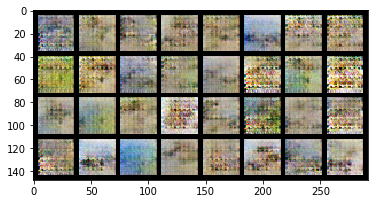

In [56]:
# MODE COLLAPSE OCCURRING WITH A LATENT SPACE OF DIMENSION 20 at epoch 25